In [72]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [73]:
# cleaning function when reading new files and set display in the notebook outputs
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [74]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [75]:
train.sample()

,Provider,PotentialFraud
3849,PRV55813,No


In [76]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
29075,BENE117536,CLM51237,2009-05-15,2009-05-21,PRV52344,7000,PHY389180,NaN,NaN,2009-05-15,79099,1068.0,2009-05-21,658,5845,41400,42832,7197,27651,4561,29281,53081,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
175393,BENE61462,CLM417374,2009-06-15,2009-06-15,PRV56575,50,PHY344772,NaN,PHY370419,53085,4019,V142,2724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [78]:
# create features for the model from the Inpatient dataset
df = inpatient.groupby('Provider').agg(
    IPInscClaimAmtReimbursedMax = ('InscClaimAmtReimbursed', 'max'),
    IPInscClaimAmtReimbursedMean = ('InscClaimAmtReimbursed', 'mean'),
    IPInscClaimAmtReimbursedSum = ('InscClaimAmtReimbursed', 'sum'),
    IPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
    IPInscClaimAmtReimburseNunique = ('InscClaimAmtReimbursed', 'nunique')
).reset_index()
df

,Provider,IPInscClaimAmtReimbursedMax,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedSum,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimburseNunique
0,PRV51001,42000,19400.000000,97000,18352.111595,5
1,PRV51003,57000,9241.935484,573000,8513.606244,18
2,PRV51007,10000,6333.333333,19000,3511.884584,3
3,PRV51008,21000,12500.000000,25000,12020.815280,2
4,PRV51011,5000,5000.000000,5000,NaN,1
...,...,...,...,...,...,...
2087,PRV57719,57000,19000.000000,76000,25350.871122,3
2088,PRV57728,6000,6000.000000,6000,NaN,1
2089,PRV57729,24000,9727.272727,107000,7226.214903,9
2090,PRV57732,17000,6909.090909,76000,4742.458127,8


In [79]:
# create features for the model from the Outpatient dataset
out_df = outpatient.groupby('Provider').agg(
    OPInscClaimAmtReimbursedMax = ('InscClaimAmtReimbursed', 'max'),
    OPInscClaimAmtReimbursedMean = ('InscClaimAmtReimbursed', 'mean'),
    OPInscClaimAmtReimbursedSum = ('InscClaimAmtReimbursed', 'sum'),
    OPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
    OPInscClaimAmtReimburseNunique = ('InscClaimAmtReimbursed', 'nunique')
).reset_index()
out_df

,Provider,OPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedSum,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimburseNunique
0,PRV51001,1500,382.000000,7640,422.817617,14
1,PRV51003,3300,466.714286,32670,821.364579,25
2,PRV51004,3300,350.134228,52170,689.963754,31
3,PRV51005,4080,241.124464,280910,491.556392,44
4,PRV51007,3300,213.188406,14710,447.231657,18
...,...,...,...,...,...,...
5007,PRV57759,3300,380.000000,10640,820.880286,14
5008,PRV57760,1100,216.818182,4770,309.998254,11
5009,PRV57761,2200,225.243902,18470,418.366092,23
5010,PRV57762,1900,1900.000000,1900,NaN,1


In [80]:
# Merge IP and OP providers to get the whole patients in one table 
provider_claims = pd.merge(
    df,  
    out_df,  
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims
provider_claims

,Provider,IPInscClaimAmtReimbursedMax,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedSum,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimburseNunique,OPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedSum,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimburseNunique
0,PRV51001,42000.0,19400.000000,97000.0,18352.111595,5.0,1500.0,382.000000,7640.0,422.817617,14.0
1,PRV51003,57000.0,9241.935484,573000.0,8513.606244,18.0,3300.0,466.714286,32670.0,821.364579,25.0
2,PRV51004,0.0,0.000000,0.0,0.000000,0.0,3300.0,350.134228,52170.0,689.963754,31.0
3,PRV51005,0.0,0.000000,0.0,0.000000,0.0,4080.0,241.124464,280910.0,491.556392,44.0
4,PRV51007,10000.0,6333.333333,19000.0,3511.884584,3.0,3300.0,213.188406,14710.0,447.231657,18.0
...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.0,0.000000,0.0,3300.0,380.000000,10640.0,820.880286,14.0
5406,PRV57760,0.0,0.000000,0.0,0.000000,0.0,1100.0,216.818182,4770.0,309.998254,11.0
5407,PRV57761,0.0,0.000000,0.0,0.000000,0.0,2200.0,225.243902,18470.0,418.366092,23.0
5408,PRV57762,0.0,0.000000,0.0,0.000000,0.0,1900.0,1900.000000,1900.0,0.000000,1.0


In [81]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)
final_df

,Provider,IPInscClaimAmtReimbursedMax,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedSum,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimburseNunique,OPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedSum,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimburseNunique,PotentialFraud
0,PRV51001,42000.0,19400.000000,97000.0,18352.111595,5.0,1500.0,382.000000,7640.0,422.817617,14.0,No
1,PRV51003,57000.0,9241.935484,573000.0,8513.606244,18.0,3300.0,466.714286,32670.0,821.364579,25.0,Yes
2,PRV51004,0.0,0.000000,0.0,0.000000,0.0,3300.0,350.134228,52170.0,689.963754,31.0,No
3,PRV51005,0.0,0.000000,0.0,0.000000,0.0,4080.0,241.124464,280910.0,491.556392,44.0,Yes
4,PRV51007,10000.0,6333.333333,19000.0,3511.884584,3.0,3300.0,213.188406,14710.0,447.231657,18.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.0,0.000000,0.0,3300.0,380.000000,10640.0,820.880286,14.0,No
5406,PRV57760,0.0,0.000000,0.0,0.000000,0.0,1100.0,216.818182,4770.0,309.998254,11.0,No
5407,PRV57761,0.0,0.000000,0.0,0.000000,0.0,2200.0,225.243902,18470.0,418.366092,23.0,No
5408,PRV57762,0.0,0.000000,0.0,0.000000,0.0,1900.0,1900.000000,1900.0,0.000000,1.0,No


In [82]:
# preper the binary column for modeling ("1,0" instead of "Yes" and "No")
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPInscClaimAmtReimbursedMax,IPInscClaimAmtReimbursedMean,IPInscClaimAmtReimbursedSum,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimburseNunique,OPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedMean,OPInscClaimAmtReimbursedSum,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimburseNunique,PotentialFraud
0,PRV51001,42000.0,19400.000000,97000.0,18352.111595,5.0,1500.0,382.000000,7640.0,422.817617,14.0,0
1,PRV51003,57000.0,9241.935484,573000.0,8513.606244,18.0,3300.0,466.714286,32670.0,821.364579,25.0,1
2,PRV51004,0.0,0.000000,0.0,0.000000,0.0,3300.0,350.134228,52170.0,689.963754,31.0,0
3,PRV51005,0.0,0.000000,0.0,0.000000,0.0,4080.0,241.124464,280910.0,491.556392,44.0,1
4,PRV51007,10000.0,6333.333333,19000.0,3511.884584,3.0,3300.0,213.188406,14710.0,447.231657,18.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.0,0.000000,0.0,3300.0,380.000000,10640.0,820.880286,14.0,0
5406,PRV57760,0.0,0.000000,0.0,0.000000,0.0,1100.0,216.818182,4770.0,309.998254,11.0,0
5407,PRV57761,0.0,0.000000,0.0,0.000000,0.0,2200.0,225.243902,18470.0,418.366092,23.0,0
5408,PRV57762,0.0,0.000000,0.0,0.000000,0.0,1900.0,1900.000000,1900.0,0.000000,1.0,0


In [83]:
# a short helper to get the relevant columns for the model features
final_df.columns

Index(['Provider', 'IPInscClaimAmtReimbursedMax',
       'IPInscClaimAmtReimbursedMean', 'IPInscClaimAmtReimbursedSum',
       'IPInscClaimAmtReimbursedStd', 'IPInscClaimAmtReimburseNunique',
       'OPInscClaimAmtReimbursedMax', 'OPInscClaimAmtReimbursedMean',
       'OPInscClaimAmtReimbursedSum', 'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimburseNunique', 'PotentialFraud'],
      dtype='object')

In [84]:
# Last preperation for modeling
# X is the features. here I will choose the feeatures that the model will try to analyze, 
# base on this data if the specific `y` (provider) is a fraud or not
X = final_df[['IPInscClaimAmtReimbursedMax',
       'IPInscClaimAmtReimbursedMean', 
       'IPInscClaimAmtReimbursedSum',
       'IPInscClaimAmtReimbursedStd',
       'IPInscClaimAmtReimburseNunique', # IP
       'OPInscClaimAmtReimbursedMax', 
       'OPInscClaimAmtReimbursedMean',
       'OPInscClaimAmtReimbursedSum', 
       'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimburseNunique']] # OP

In [85]:
# 
y = final_df['PotentialFraud']

In [86]:
# 1. Split
# Now we'll splpit the data into train and test, usually, 80% train in my case here.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [87]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [88]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [89]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [90]:
# Now it's time to create the confusion matrix.
# in sklearn, the setup for it is: TP is the bottom right, FN bottom left, TN top left and FP top right.
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[961  16]
 [ 62  43]]


In [91]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.73
Recall: 0.41
F1 Score: 0.52


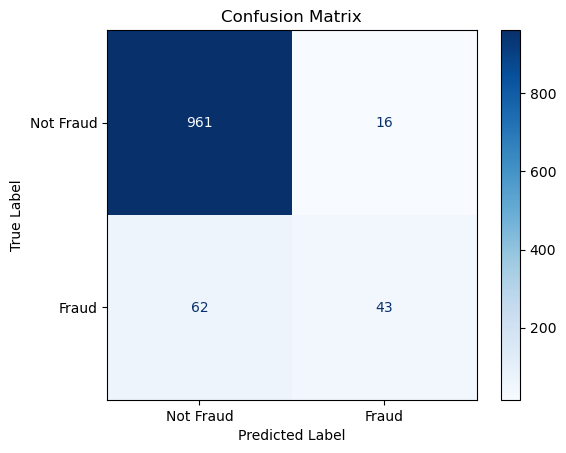

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

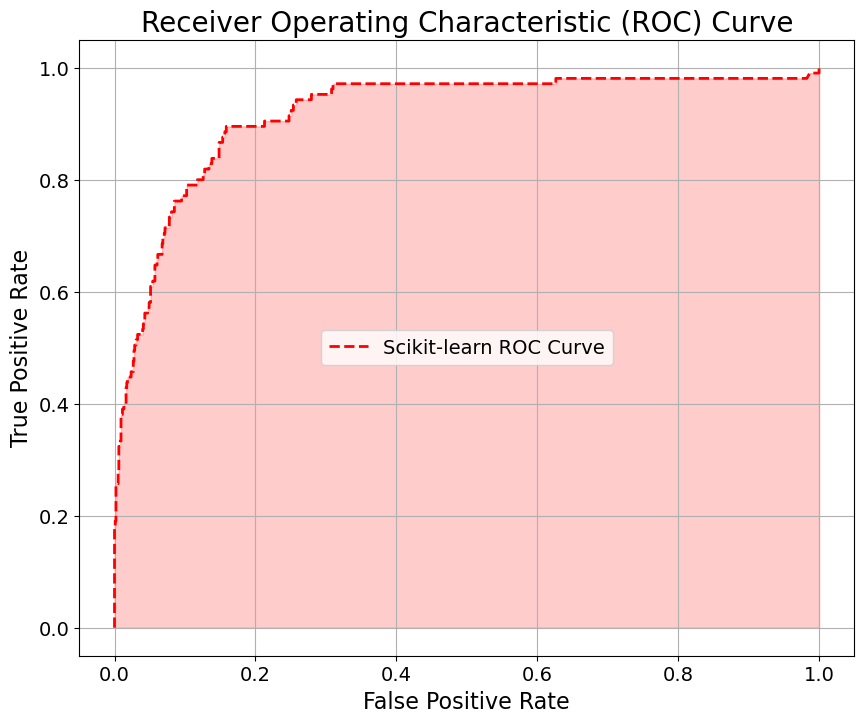

In [93]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Fill under the ROC curve
ax.fill_between(fpr, tpr, alpha=0.2, color='red')  # alpha=0.2 makes it somewhat transparent
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [58]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9185650923624311)

# This park suppose to help me to fine tune the best accuracy (which is not the most important now)

In [59]:
# Perform Sequential Feature Selector with n=1 and build on above code
from sklearn.feature_selection import SequentialFeatureSelector
# I can adjust the n_features_to_select: 1, to get the best feature, 
# 2 will give me more, but unnecessary combine them will give the bset results.
sfs = SequentialFeatureSelector(model, n_features_to_select=4)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=42),
                          n_features_to_select=4)

In [60]:
selected_features = X.columns[sfs.get_support()].to_list()
print(f"Features selected by SFS: {selected_features}")

Features selected by SFS: ['IPInscClaimAmtReimbursedMean', 'IPInscClaimAmtReimbursedSum', 'IPInscClaimAmtReimbursedStd', 'OPInscClaimAmtReimbursedSum']


### loooking for a better threshold to find better f1 score:

In [24]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [25]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.16112487056785005


In [26]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[907  70]
 [ 30  75]]


array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.73
Recall: 0.41
F1 Score: 0.52


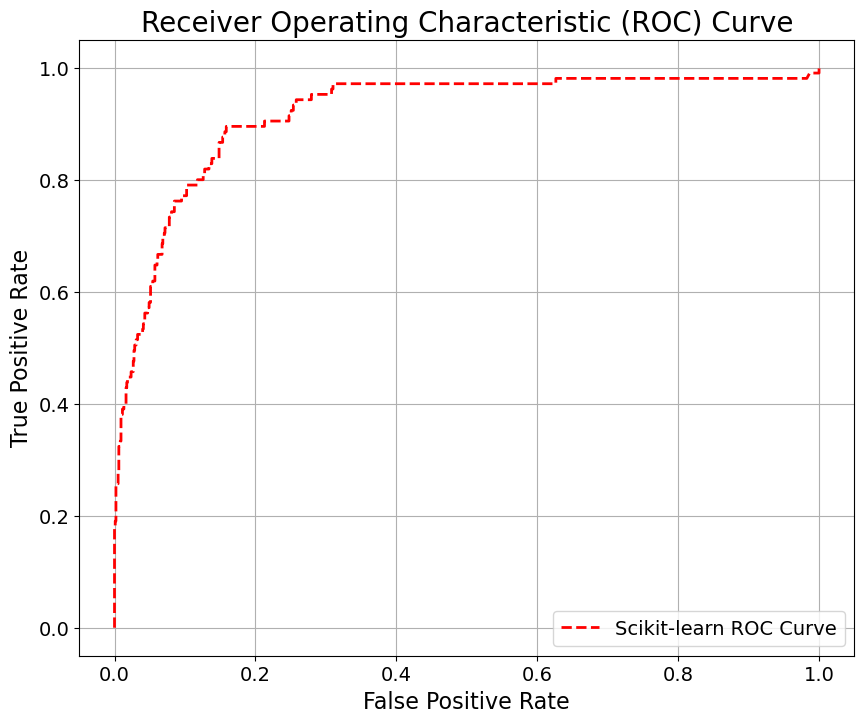

In [32]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [33]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9185650923624311)

# This part is here to check only a few freaturs for the model from the ones above

In [94]:
X = final_df[['IPInscClaimAmtReimbursedMean', 
              'IPInscClaimAmtReimbursedSum', 
              'IPInscClaimAmtReimbursedStd', 
              'OPInscClaimAmtReimbursedSum']] # OP

In [95]:
y = final_df['PotentialFraud']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [97]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [98]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [99]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [100]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[964  13]
 [ 64  41]]


In [101]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.76
Recall: 0.39
F1 Score: 0.52


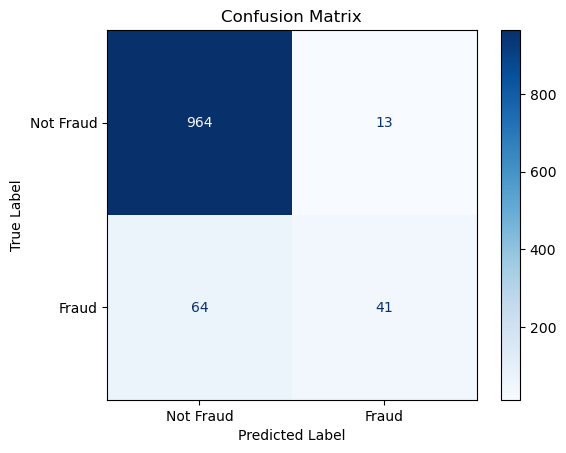

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

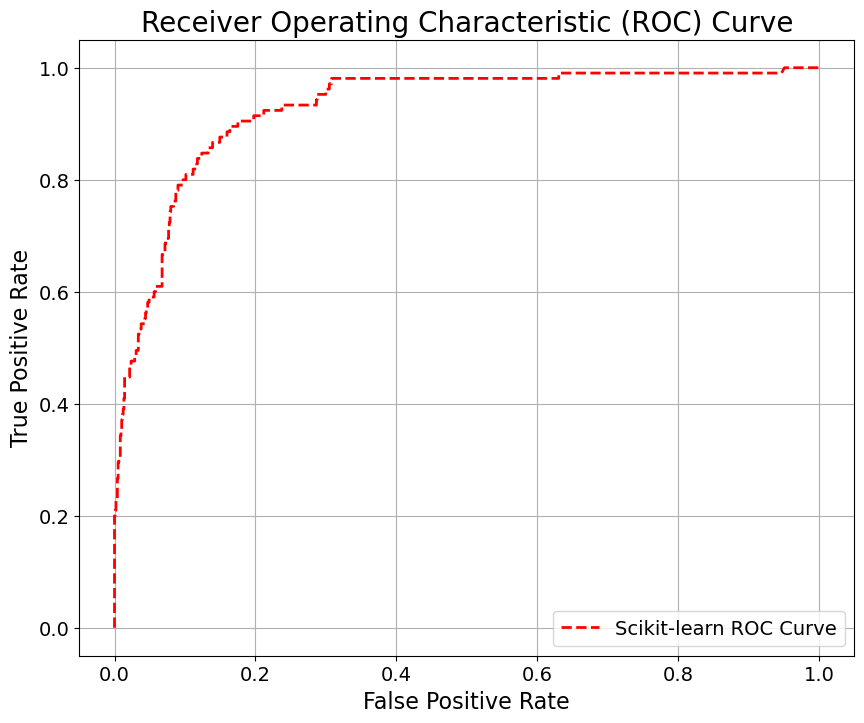

In [103]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [104]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9276599892771846)